In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
import joblib
import os

input_dir = '/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering'   # fixed folder name
output_dir = '/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation'

# Load BoW and N-grams feature dataframes
df_bow = pd.read_pickle(os.path.join(input_dir, 'features_bow.pkl'))
df_ngram = pd.read_pickle(os.path.join(input_dir, 'features_ngram2.pkl'))

# Load corresponding vectorizers
bow_vectorizer = joblib.load(os.path.join(input_dir, 'vectorizer_bow.pkl'))
ngram_vectorizer = joblib.load(os.path.join(input_dir, 'vectorizer_ngram2.pkl'))

# Prepare labels
y = df_bow['label_num'].values

# Drop label columns
X_bow = df_bow.drop(['label', 'label_num'], axis=1).values
X_ngram = df_ngram.drop(['label', 'label_num'], axis=1).values

# Combine BoW + N-gram features
X_combined = np.hstack([X_bow, X_ngram])

# Train model
model = MultinomialNB()
model.fit(X_combined, y)

# Save everything
os.makedirs(output_dir, exist_ok=True)
joblib.dump(model, os.path.join(output_dir, 'naive_bayes_bow_ngram.pkl'))
joblib.dump(bow_vectorizer, os.path.join(output_dir, 'bow_vectorizer.pkl'))
joblib.dump(ngram_vectorizer, os.path.join(output_dir, 'ngram2_vectorizer.pkl'))

print(f"Champion Naive Bayes model trained and saved to:\n{output_dir}")


Champion Naive Bayes model trained and saved to:
/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation


Create the Prediction Inference & Code Export predictions

In [ ]:
import numpy as np
import pandas as pd
import joblib

# Paths to saved model and vectorizers
MODEL_PATH = '/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation/naive_bayes_bow_ngram.pkl'
BOW_VECTORIZER_PATH = '/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation/bow_vectorizer.pkl'
NGRAM_VECTORIZER_PATH = '/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation/ngram2_vectorizer.pkl'

# Load trained model and vectorizers once
model = joblib.load(MODEL_PATH)
bow_vectorizer = joblib.load(BOW_VECTORIZER_PATH)
ngram_vectorizer = joblib.load(NGRAM_VECTORIZER_PATH)

# Define label mapping (update as needed)
label_map = {
    0: 'Gene Expression Analysis',
    1: 'Sequence Classification',
    2: 'Protein Structure Prediction',
    3: 'Biological Image Analysis',
    4: 'Disease Outcome Prediction'
}

def predict_paper_category(text):
    # Transform input text to features
    bow_features = bow_vectorizer.transform([text])
    ngram_features = ngram_vectorizer.transform([text])

    # Combine BoW + N-gram features horizontally
    X = np.hstack([bow_features.toarray(), ngram_features.toarray()])

    # Predict label number and map to label string
    label_num = model.predict(X)[0]
    return label_map[label_num]

# Load your labeled dataset (make sure the 'Text' column exists)
df = pd.read_excel('/content/drive/My Drive/Colab/AS4/STEP1-data_prepare/final_labeled_dataset.xlsx')

# Apply prediction to each text entry (this may take some time)
df['predicted_Classification_label'] = df['Text'].apply(predict_paper_category)
# Save the DataFrame with predicted labels
output_path = '/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation/Raw_with_predicted_classification_label.xlsx'
df.to_excel(output_path, index=False)

print(f"Prediction complete and saved to:\n{output_path}")


Prediction complete and saved to:
/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation/Raw_with_predicted_classification_label.xlsx


**Error Analysis**

1. Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import joblib
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)

from itertools import cycle


2. Load and Prepare Data

In [6]:
# Load main cleaned dataset
df = pd.read_excel("/content/drive/My Drive/Colab/AS4/STEP1-data_prepare/final_labeled_dataset.xlsx")

# Text and textual labels
texts = df['Text'].values
labels_text = df['Label'].values

# Encode labels (this defines your official mapping)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels_text)

# Confirm class mapping
print(" Encoded Classes:", dict(zip(le.classes_, range(len(le.classes_)))))
num_classes = len(le.classes_)

# Load BoW and N-gram engineered features
DPPpath = '/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/'

# Load preprocessed features
df_bow = pd.read_pickle(DPPpath + 'features_bow.pkl')
df_ngram = pd.read_pickle(DPPpath + 'features_ngram2.pkl')


#  Overwrite `label_num` in both dataframes using `le`
df_bow['label_num'] = le.transform(df_bow['label'])
df_ngram['label_num'] = le.transform(df_ngram['label'])

# Extract features and aligned label vector
X_bow = df_bow.drop(['label', 'label_num'], axis=1).values
X_ngram = df_ngram.drop(['label', 'label_num'], axis=1).values
X_combined = np.hstack([X_bow, X_ngram])
y = df_bow['label_num'].values  # Safe now; consistent with LabelEncoder

 Encoded Classes: {'biological image analysis': 0, 'disease outcome prediction': 1, 'gene expression analysis': 2, 'protein structure and function prediction': 3, 'sequence classification and alignment': 4}


3. Load Features and Combine

4. Train-Test Split

In [7]:
X_train, X_test, y_train, y_test, texts_train, texts_test = train_test_split(
    X_combined, y, texts, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 800, Test size: 200


5. Train and Evaluate Naive Bayes

In [8]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Test Accuracy: 0.8750

Classification Report:
                                           precision    recall  f1-score   support

                biological image analysis       0.91      0.72      0.81        40
               disease outcome prediction       0.80      0.97      0.88        40
                 gene expression analysis       0.95      0.95      0.95        40
protein structure and function prediction       0.85      0.97      0.91        40
    sequence classification and alignment       0.91      0.75      0.82        40

                                 accuracy                           0.88       200
                                macro avg       0.88      0.88      0.87       200
                             weighted avg       0.88      0.88      0.87       200


Confusion Matrix:
[[29  7  2  1  1]
 [ 1 39  0  0  0]
 [ 0  1 38  0  1]
 [ 0  0  0 39  1]
 [ 2  2  0  6 30]]


6. Confusion Matrix Heatmap

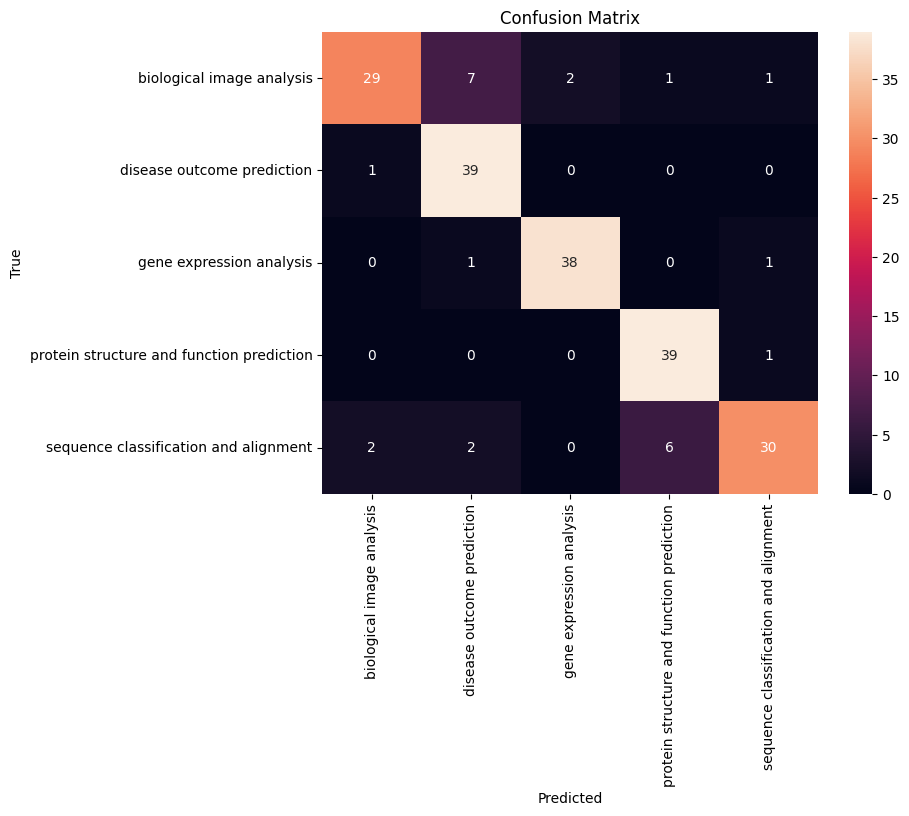

'biological image analysis' misclassified as 'disease outcome prediction': 7 times
'biological image analysis' misclassified as 'gene expression analysis': 2 times
'biological image analysis' misclassified as 'protein structure and function prediction': 1 times
'biological image analysis' misclassified as 'sequence classification and alignment': 1 times
'disease outcome prediction' misclassified as 'biological image analysis': 1 times
'gene expression analysis' misclassified as 'disease outcome prediction': 1 times
'gene expression analysis' misclassified as 'sequence classification and alignment': 1 times
'protein structure and function prediction' misclassified as 'sequence classification and alignment': 1 times
'sequence classification and alignment' misclassified as 'biological image analysis': 2 times
'sequence classification and alignment' misclassified as 'disease outcome prediction': 2 times
'sequence classification and alignment' misclassified as 'protein structure and functio

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
import numpy as np

# Assuming `cm` is your confusion matrix and `le.classes_` is the label list
for true_idx, true_label in enumerate(le.classes_):
    for pred_idx, pred_label in enumerate(le.classes_):
        if true_idx != pred_idx and cm[true_idx, pred_idx] > 0:
            print(f"'{true_label}' misclassified as '{pred_label}': {cm[true_idx, pred_idx]} times")


7. Error Analysis

In [10]:
errors = np.where(y_pred != y_test)[0]
print(f"\nNumber of errors: {len(errors)}")

print("\nSample misclassified texts:")
for i in errors[:10]:
    print(f"\nText: {texts_test[i]}")
    print(f"True label: {le.inverse_transform([y_test[i]])[0]}")
    print(f"Predicted label: {le.inverse_transform([y_pred[i]])[0]}")



Number of errors: 25

Sample misclassified texts:

Text: accurate discrimination outer membrane protein using secondary structure element alignment support vector machine outer membrane protein omps play critical role many cellular process discriminating omps type protein important omps identification bacterial genomic protein study method ssea svm developed using secondary structure element alignment support vector machine moreover novel kernel function designed utilize secondary structure information support vector machine classifier benchmark dataset consists omps globular protein alphahelical membrane protein used evaluate performance ssea svm high accuracy mcc achieved ssea svm applied discriminating omps nonomps comparison existing method literature ssea svm also highly competitive suggest ssea svm much promising method identify omps genomic protein web server implement ssea svm freely available httpbioinfotmmueducnsseasvm
True label: sequence classification and alignment
Predic

 8. ROC-AUC and Curves

In [11]:
y_proba = model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

roc_auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
roc_auc_weighted = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class='ovr')
print(f"\nROC AUC (macro-average): {roc_auc_macro:.4f}")
print(f"ROC AUC (weighted-average): {roc_auc_weighted:.4f}")



ROC AUC (macro-average): 0.9825
ROC AUC (weighted-average): 0.9825


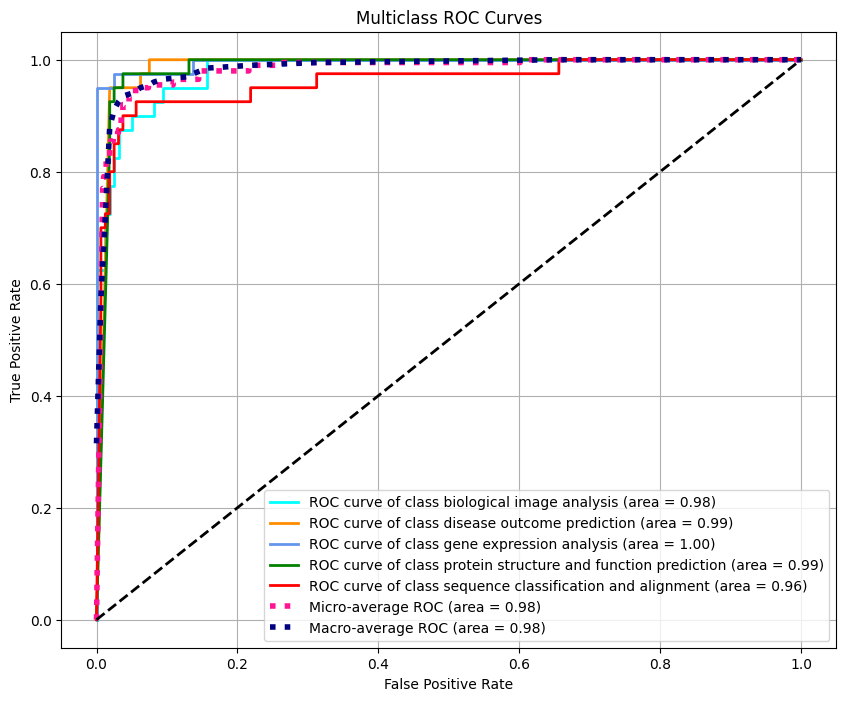

In [12]:
#  ROC Curve Plot
fpr, tpr, roc_auc = {}, {}, {}
n_classes = len(le.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.mean([np.interp(all_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=4, color='deeppink',
         label=f'Micro-average ROC (area = {roc_auc["micro"]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=4, color='navy',
         label=f'Macro-average ROC (area = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


9. SHAP Analysis Setup and SHAP Values + Summary Plot

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Multinom

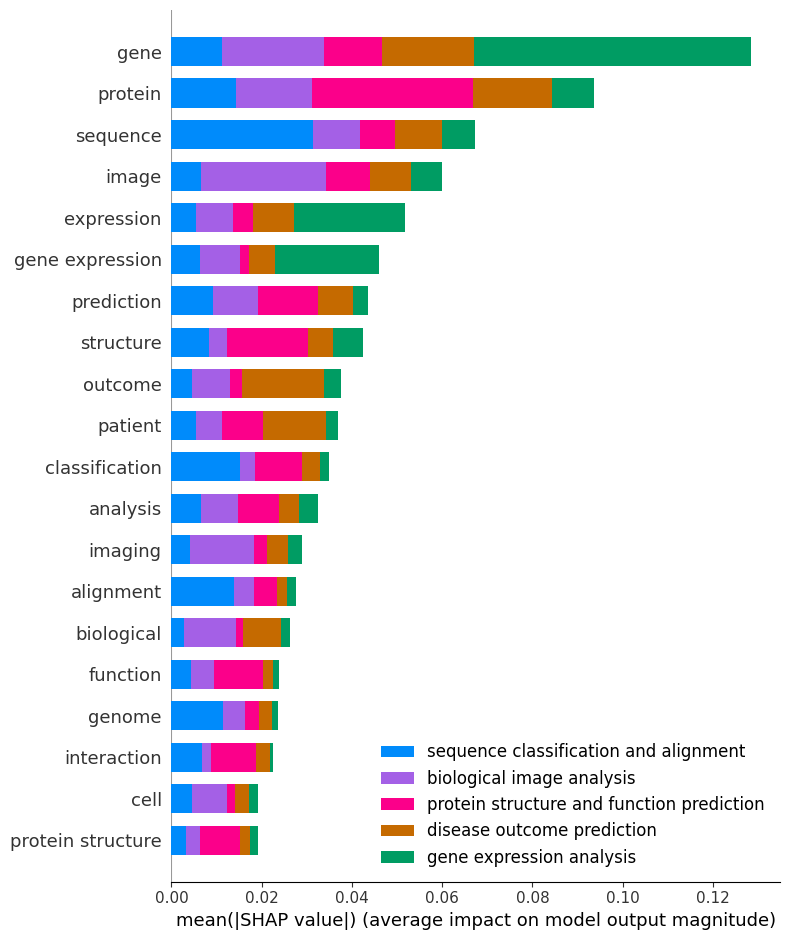

In [15]:
# --- Step 9: SHAP Setup (recomputing top chi2 features) ---
from sklearn.feature_selection import SelectKBest, chi2

# Recompute chi2-selected top 500 features on BoW+Ngram
selector = SelectKBest(chi2, k=500)
X_combined_reduced = selector.fit_transform(X_combined, y)
selected_feature_indices = selector.get_support(indices=True)

# Create train/test split with reduced features
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_combined_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Fit model on reduced features
model_reduced = MultinomialNB()
model_reduced.fit(X_train_reduced, y_train_reduced)

# Load vectorizers
vectorizer_bow = joblib.load("/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/vectorizer_bow.pkl")
vectorizer_ngram = joblib.load("/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/vectorizer_ngram2.pkl")

# Get feature names
feature_names_bow = vectorizer_bow.get_feature_names_out()
feature_names_ngram = vectorizer_ngram.get_feature_names_out()
all_feature_names = np.concatenate([feature_names_bow, feature_names_ngram])

# Select the feature names corresponding to top chi2 features
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]

# Prepare DataFrame for SHAP
X_test_df = pd.DataFrame(
    X_test_reduced.toarray() if hasattr(X_test_reduced, "toarray") else X_test_reduced,
    columns=selected_feature_names
)

# --- Step 10: Compute SHAP Values ---
explainer = shap.Explainer(
    model_reduced.predict_proba, X_test_df, algorithm="permutation",
    max_evals=2 * X_test_df.shape[1] + 1
)
shap_values = explainer(X_test_df)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_df, feature_names=selected_feature_names, class_names=le.classes_)


10. Global SHAP Feature Importance

In [16]:
# Average SHAP value per feature (mean over all instances and classes)
mean_shap = np.abs(shap_values.values).mean(axis=(0, 2))

top_n = 20
top_indices = np.argsort(mean_shap)[-top_n:][::-1]

print(f"\nTop {top_n} most influential words across all classes:")
for i in top_indices:
    print(f"{selected_feature_names[i]:<20}  SHAP = {mean_shap[i]:.4f}")



Top 20 most influential words across all classes:
gene                  SHAP = 0.0257
protein               SHAP = 0.0187
sequence              SHAP = 0.0135
image                 SHAP = 0.0120
expression            SHAP = 0.0103
gene expression       SHAP = 0.0092
prediction            SHAP = 0.0087
structure             SHAP = 0.0085
outcome               SHAP = 0.0075
patient               SHAP = 0.0074
classification        SHAP = 0.0070
analysis              SHAP = 0.0065
imaging               SHAP = 0.0058
alignment             SHAP = 0.0055
biological            SHAP = 0.0052
function              SHAP = 0.0048
genome                SHAP = 0.0047
interaction           SHAP = 0.0045
cell                  SHAP = 0.0038
protein structure     SHAP = 0.0038


11. SHAP Error vs Correct Analysis

In [17]:
# Label mapping for class name reference
label_map = {i: name for i, name in enumerate(le.classes_)}
num_classes = len(le.classes_)

# Get predicted probabilities and final predictions
y_pred_reduced = model_reduced.predict(X_test_reduced)

# Indices of misclassified and correctly classified instances
error_indices = np.where(y_test_reduced != y_pred_reduced)[0]
correct_indices = np.where(y_test_reduced == y_pred_reduced)[0]

# Collect SHAP values for true class only
shap_true_correct = {cls: [] for cls in range(num_classes)}
shap_true_errors = {cls: [] for cls in range(num_classes)}

for i in correct_indices:
    true_cls = y_test_reduced[i]
    shap_true_correct[true_cls].append(shap_values.values[i, :, true_cls])
for i in error_indices:
    true_cls = y_test_reduced[i]
    shap_true_errors[true_cls].append(shap_values.values[i, :, true_cls])

# Convert to arrays
for cls in range(num_classes):
    shap_true_correct[cls] = np.array(shap_true_correct[cls]) if shap_true_correct[cls] else np.empty((0, len(selected_feature_names)))
    shap_true_errors[cls] = np.array(shap_true_errors[cls]) if shap_true_errors[cls] else np.empty((0, len(selected_feature_names)))

# Compute average SHAP values per feature
mean_correct_shap = {
    cls: shap_true_correct[cls].mean(axis=0) if shap_true_correct[cls].size > 0 else np.zeros(len(selected_feature_names))
    for cls in range(num_classes)
}
mean_error_shap = {
    cls: shap_true_errors[cls].mean(axis=0) if shap_true_errors[cls].size > 0 else np.zeros(len(selected_feature_names))
    for cls in range(num_classes)
}


In [18]:
# What Words Help or Hurt the Model?
# Words Boosting Correct Classification
print(" Top words contributing to CORRECT classification (per class):")
for cls in range(num_classes):
    print(f"\nClass '{label_map[cls]}':")
    sorted_idx = np.argsort(mean_correct_shap[cls])[::-1]
    for idx in sorted_idx[:10]:
        if mean_correct_shap[cls][idx] > 0:
            print(f"  {selected_feature_names[idx]}: {mean_correct_shap[cls][idx]:.4f}")


 Top words contributing to CORRECT classification (per class):

Class 'biological image analysis':
  image: 0.0784
  gene: 0.0505
  imaging: 0.0355
  protein: 0.0312
  biological: 0.0220
  sequence: 0.0204
  gene expression: 0.0177
  segmentation: 0.0169
  expression: 0.0158
  outcome: 0.0156

Class 'disease outcome prediction':
  gene: 0.0481
  outcome: 0.0402
  protein: 0.0351
  patient: 0.0269
  expression: 0.0198
  sequence: 0.0192
  disease: 0.0174
  biological: 0.0162
  prediction: 0.0160
  heart: 0.0145

Class 'gene expression analysis':
  gene: 0.1402
  expression: 0.0587
  gene expression: 0.0533
  protein: 0.0182
  sequence: 0.0175
  image: 0.0151
  cancer: 0.0139
  expression data: 0.0137
  pathway: 0.0135
  structure: 0.0128

Class 'protein structure and function prediction':
  protein: 0.0653
  structure: 0.0359
  gene: 0.0333
  protein structure: 0.0267
  prediction: 0.0267
  image: 0.0182
  analysis: 0.0181
  function: 0.0180
  patient: 0.0161
  scoring function: 0.0155


In [19]:
# Words Hurting Predictions for True Class
print("\n Top words negatively contributing to TRUE class in misclassifications (per class):")
for cls in range(num_classes):
    print(f"\nClass '{label_map[cls]}':")
    sorted_idx = np.argsort(mean_error_shap[cls])
    for idx in sorted_idx[:10]:
        if mean_error_shap[cls][idx] < 0:
            print(f"  {selected_feature_names[idx]}: {mean_error_shap[cls][idx]:.4f}")



 Top words negatively contributing to TRUE class in misclassifications (per class):

Class 'biological image analysis':
  treatment: -0.0786
  sequence: -0.0491
  model: -0.0401
  survival: -0.0283
  enzyme: -0.0228
  predictive: -0.0118
  cell: -0.0106
  lasso: -0.0093
  expression: -0.0082
  longterm: -0.0078

Class 'disease outcome prediction':
  plant: -0.0390
  image processing: -0.0300
  network: -0.0198
  outcome: -0.0198
  deep: -0.0163
  texture: -0.0161
  image: -0.0149
  diabetes: -0.0137
  risk: -0.0122
  heart: -0.0121

Class 'gene expression analysis':
  ml: -0.1707
  patient outcome: -0.0541
  gene: -0.0530
  ml model: -0.0324
  interaction: -0.0170
  clinical: -0.0137
  model: -0.0119
  information: -0.0119
  outcome: -0.0118
  cancer: -0.0117

Class 'protein structure and function prediction':

Class 'sequence classification and alignment':
  ml: -0.0639
  structure: -0.0602
  analysis: -0.0322
  drug discovery: -0.0226
  structure prediction: -0.0208
  residue: -0.02